## Regularized linear model regression and visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read file
def ReadFile(file_path):
    file = open(file_path, mode='r')
    line = file.readline()
    data_points = []
    while line:
        x,y = map(float,line.strip().split(','))
        data_points.append((x,y))
        line = file.readline()   
        
    data_array = np.array(data_points)
    A = data_array[:,0].reshape(1, -1) #[1,n]
    b = data_array[:,1].reshape(-1, 1) 
    return data_points, A, b

### LU Decomposition for inverse
LU decomposition:<br>
to find A-1, that [A][A-1] = [I]<br>
step1: using [A] = [L][U]<br>
step2: find [Y], that [Y] = [U][A-1] => [A][A-1] = [L][U][A-1] = [L][Y] = [I]<br>
step3: find [A-1], that [Y] = [U][A-1]

In [3]:
# lambda matrix
def lambdaM(size, lambda_value):
    M = np.identity(size) * lambda_value
    return M

In [4]:
# zero matrix
def zeroM(size):
    M = np.zeros((size, size))
    return M

In [5]:
# LU decomposition A=LU
def LUDecomposition(A):
    n = A.shape[0]
    L = zeroM(n)
    U = A.copy()
    for i in range(n):
        L[i][i] = 1.0
        for j in range(i+1, n):
            scalar = U[j][i]/U[i][i]
            L[j][i] = scalar
            for k in range (n):
                U[j][k] -= scalar* U[i][k]
    return L, U
            

In [6]:
# find [Y], that [L][Y] = [I]
def FindY(L):
    n = L.shape[0]
    Y = zeroM(n)
    I = np.identity(n)
    # for every column solve Ly = b
    for i in range(n):
        b = I[:, i]
        y = np.zeros_like(b, dtype=np.float64)
        for row in range(n):
            y[row] = b[row]
            for col in range(row):
                y[row] -= L[row][col] * y[col]
            y[row] /= L[row][row]
        
        Y[:, i] = y
    return Y

In [7]:
# find [X], that [Y] = [U][X]
def FindX(Y, U):
    n = U.shape[0]
    X = np.zeros_like(Y)    
    # For every column, solve Ux = y
    for i in range(Y.shape[1]):
        y = Y[:, i]
        x = np.zeros_like(y, dtype=np.float64)
        for row in reversed(range(n)):
            x[row] = y[row]
            for col in range(row + 1, n):
                x[row] -= U[row][col] * x[col]
            x[row] /= U[row][row]
        
        X[:, i] = x
    
    return X

In [8]:
# Find inverse using LU decomposition
# to find A-1, that [A][A-1] = [I]
# step1: using [A] = [L][U]
# step2: find [Y], that [Y] = [U][A-1] => [A][A-1] = [L][U][A-1] = [L][Y] = [I]
# step3: find [X] = [A-1], that [Y] = [U][X]
def FindInverse(A):
    # step1: using [A] = [L][U]
    L, U = LUDecomposition(A)
    # step2: find [Y], that [L][Y] = [I]
    Y = FindY(L)
    # step3: find [X], that [Y] = [U][X]
    Inverse = FindX(Y,U)
    
    return Inverse
    

In [9]:
# design matrix phi
#|..., x1^2, x1^1, 1|
#|..., x2^2, x2^1, 1|
#|..., x3^2, x3^1, 1|
def phiM(A,N):
    m = len(A[0])    
    M = np.zeros((m,N))
    for i in range(len(M)):
        for j in range(N):
            M[i][N-1-j] = A[0][i]**j
    return M

### Output

In [10]:
# output of LSE
def Output(X,N):
    print("Fitting line: ", end="")
    for idx, item in enumerate(X.flat):
        if idx== N-1:
            print(item)
        else:
            print(f"{item} X^{N-1-idx}",end=" + ")

In [11]:
# Error = ((phix-b)^2+ lambda|x|^2)
def Error(phi, b, X, N, lambda_value,method):
    error = 0.0
    for i in range(len(phi)):
        y_pred = 0.0
        for j in range(N):
            y_pred += phi[i][j] * X[j]
        error += (y_pred - b[i])**2
    if method==1:
        for j in range(N):
            error += lambda_value * (X[j]**2)
    elif method ==2:
        for j in range(N):
            error += lambda_value * (np.abs(X[j]))
    print(f"Total error: {error}")  

### Main

File_name: testfile.txt
The number of polynomial bases n: 3
Lambda for rLSE and Steepest Descent: 10000
Max iteration for Steepest Descent: 10000
Learning rate for Steepest Descent: 0.00001
 
LSE:
Fitting line: 0.834533282700286 X^2 + 0.09314819831918818 X^1 + 0.046950699273469274
Total error: 29723.00604249309

Steepest descent:
Fitting line: 1.67348596432416 X^2 + -0.03488482199691706 X^1 + 0.056732763573644124
Total error: 29361.506124128417

Newton's method:
Fitting line: 3.0238533934865712 X^2 + 4.906190263863799 X^1 + -0.2314017560877098
Total error: 26.55995949933308


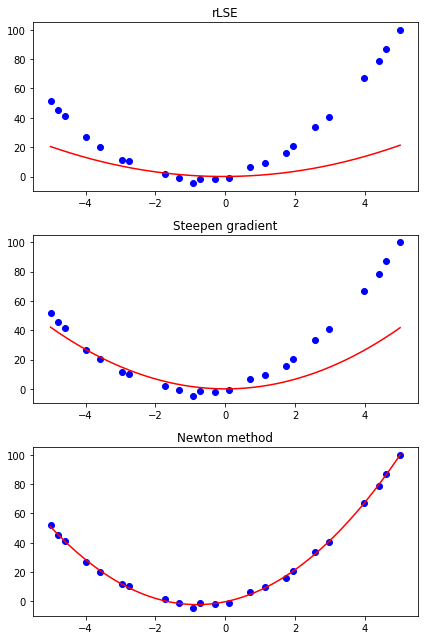

In [15]:
# Input parameters
file_name = input("File_name: ") # testfile.txt
N = int(input("The number of polynomial bases n: "))
lambda_ = float(input("Lambda for rLSE and Steepest Descent: "))
max_it = int(input("Max iteration for Steepest Descent: ")) # 1000
lr = float(input("Learning rate for Steepest Descent: ")) # 0.0001
print(" ")
# read data
data_points, A, b = ReadFile(file_name)
size = len(A[0])
phi = phiM(A,N)
phiT = phi.T

# rLSE
# X = (phiT*phi+ lambda*I)^-1*phiT*b
Inverse = FindInverse(np.dot(phiT, phi) +lambdaM(N, lambda_))
X1 = np.squeeze(np.dot(np.dot(Inverse, phiT), b))
b = np.squeeze(b)
method =1
print('LSE:')
Output(X1,N)
Error(phi, b, X1, N, lambda_, method)

# Steepest descent
# x <- x - lr*(grad_LSE + grad_L1)
# x <- x - lr*(2PhiT(Phix-b)+ lambda sign x)
X2 = np.zeros(N)
for _ in range(max_it):
    grad_LSE = 2 * np.dot(phiT, (np.dot(phi, X2) - b))
    grad_L1 = lambda_ * np.sign(X2)
    grad = grad_LSE + grad_L1
    X2 -= lr * grad
method = 2
print('\nSteepest descent:')
Output(X2,N)
Error(phi, b, X2, N, lambda_,method)

# Newton's method
# X <- X - Hessian^-1* gradient(X)
# Hessian = 2phiTphi
# gradient = 2phiTphix-2phiTb
X3 = np.zeros(N)
gradient = 2*np.dot(np.dot(phiT,phi),X3) - 2*np.dot(phiT,b)
hessian = 2* np.dot(phiT,phi)
hessian_inv = FindInverse(hessian)
X3 = X3 - np.dot(hessian_inv,gradient)
method = 3
print("\nNewton's method:")
Output(X3,N)
Error(phi, b, X3, N, lambda_,method )

# Visualize
titles = ['rLSE', 'Steepen gradient', 'Newton method']

plt.figure(figsize=(6, 9))

for i, (coeffs, title) in enumerate(zip([X1, X2, X3], titles)):
    plt.subplot(3, 1, i+1)
    # Plot data points
    plt.scatter(A, b, color='blue', label='Data Points')

    # Plot curve
    x_range = np.linspace(min(A[0]), max(A[0]), 500)  # Adjust x_range calculation
    y_range = np.polyval(coeffs, x_range)
    plt.plot(x_range, y_range, color='red')
    
    plt.title(title)
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()